# Ichimoku + StochRSI + EMA
### buy--condition = EMA  < Close > SSA and Close > SSB and StochRSI < 0.8 
### sell--condition = Close < SSA and Close < SSB and StochRSI > 0.2 

In [10]:
import pandas as pd
from binance.client import Client
import ta
import matplotlib.pyplot as plt

client = Client()

klinesT = client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_1HOUR, "01 september 2017")

df = pd.DataFrame(klinesT, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
df['close'] = pd.to_numeric(df['close'])
df['high'] = pd.to_numeric(df['high'])
df['low'] = pd.to_numeric(df['low'])
df['open'] = pd.to_numeric(df['open'])

del df['ignore']
del df['close_time']
del df['quote_av']
del df['trades']
del df['tb_base_av']
del df['tb_quote_av']

df = df.set_index(df['timestamp'])
df.index = pd.to_datetime(df.index, unit='ms')
del df['timestamp']
print(df)

                         open      high       low     close         volume
timestamp                                                                 
2017-09-01 00:00:00   4689.89   4745.35   4689.89   4721.05    15.71167300
2017-09-01 01:00:00   4730.05   4766.99   4701.11   4725.00    28.11134400
2017-09-01 02:00:00   4740.99   4767.00   4723.00   4735.96    15.14069300
2017-09-01 03:00:00   4767.00   4767.00   4713.67   4714.73    16.68426800
2017-09-01 04:00:00   4714.73   4734.99   4672.00   4672.00    40.82352800
...                       ...       ...       ...       ...            ...
2022-02-19 10:00:00  39926.26  39974.98  39757.43  39946.01   964.02501000
2022-02-19 11:00:00  39946.01  40032.70  39648.60  39842.54  1713.61364000
2022-02-19 12:00:00  39842.53  39950.00  39661.30  39754.99  1161.48600000
2022-02-19 13:00:00  39754.98  40076.94  39639.03  40017.88  1224.64172000
2022-02-19 14:00:00  40017.88  40017.88  39868.00  39878.69   374.27861000

[39057 rows x 5 columns]

       i        result
40  78.0   6888.103881
41  79.0   8075.976003
43  81.0   9324.262426
33  71.0   9429.628550
34  72.0   9579.870944
36  74.0   9585.580697
38  76.0   9735.645833
42  80.0  10080.021401
39  77.0  10094.898262
48  86.0  10373.214836
35  73.0  10777.477380
25  63.0  11212.781202
51  89.0  11503.248793
19  57.0  11508.680349
37  75.0  11732.099491
20  58.0  11775.540377
30  68.0  12002.491495
31  69.0  12344.609663
26  64.0  12369.649929
50  88.0  12370.498586
46  84.0  12377.856375
47  85.0  12484.559576
32  70.0  12557.689695
16  54.0  12621.722210
44  82.0  12902.742187
23  61.0  12954.047370
45  83.0  13095.855912
49  87.0  13180.846976
21  59.0  13211.729251
12  50.0  13264.590947
24  62.0  13453.945840
11  49.0  13650.050017
18  56.0  13808.292360
9   47.0  13880.254872
8   46.0  14027.356129
17  55.0  14311.658121
15  53.0  14341.473245
27  65.0  14746.057963
29  67.0  14939.551750
10  48.0  14962.068938
22  60.0  14987.176245
6   44.0  15020.990422
28  66.0  1

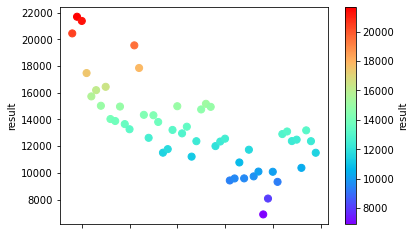

In [14]:
dt = None
dt = pd.DataFrame(columns = ['i', 'result'])
count=0

for i in range(38,90):
    df['SSA'] = ta.trend.ichimoku_a(df['high'],df['low'],3,38).shift(periods=i)
    df['SSB'] = ta.trend.ichimoku_b(df['high'],df['low'],38,46).shift(periods=i)
    dfTest = df.copy()
    usdt = 1000
    coin = 0
    fee = 0.0007
    wallet = 1000

    for index, row in dfTest.iterrows():
        #BUY
        if row['close']>row['SSA'] and row['close']>row['SSB'] and row['STOCH_RSI'] < 0.8 and row['close']>row['EMA50'] and usdt > 0:
            buyPrice = row['close']
            coin = usdt/buyPrice
            coin = coin - fee*coin
            usdt = 0
            wallet = coin * row['close']
            #print("buy btc at ",df['close'][index]," || ",df['timestamp'][index], " || I have ",fiat,"$ and ",btc," btc")
        #SELL
        if (row['close'] < row['SSA'] or row['close'] < row['SSB']) and row['STOCH_RSI'] > 0.2 and coin > 0:
            sellPrice = row['close']
            usdt = coin*sellPrice
            usdt = usdt - fee*usdt
            coin = 0
            wallet = usdt
            #print("sell btc at ",df['close'][index]," || ",df['timestamp'][index], "|| I have ",fiat,"$ and ",btc," btc")
    myrow = {'i': i,'result': wallet}
    dt = dt.append(myrow,ignore_index=True) 
print(dt.sort_values(by=['result']))
dt.plot.scatter(x='i',y=1,c='result',s=50,colormap='rainbow') 
plt.show()

In [19]:
df.drop(df.columns.difference(['open','high','low','close','volume']), 1, inplace=True)
df['EMA50']=ta.trend.ema_indicator(df['close'], 50)
# df['RSI'] =ta.momentum.rsi(df['close'],14)
# df['Hrsi'] =df['rsi'].rolling(14).max()
# df['Lrsi'] =df['rsi'].rolling(14).min()
# df['stoch_rsi'] = (df['rsi'] - df['Lrsi']) / (df['Hrsi'] - df['Lrsi'])
# df['histo_macd']=ta.trend.macd_diff(df['close'], 26, 12, 9)
# df['EMA28']=ta.trend.ema_indicator(df['close'], 28)
# df['EMA48']=ta.trend.ema_indicator(df['close'], 48)
# df['MACD']=ta.trend.macd(df['close'], 26, 12, 9)
# df['MACD_SIGNAL']=ta.trend.macd_signal(df['close'], 26, 12, 9)
# df['MACD_HISTO']= df['MACD'] - df['MACD_SIGNAL']
# df['EMA8']=ta.trend.ema_indicator(df['close'], 8)
# df['EMA14']=ta.trend.ema_indicator(df['close'], 14)
# df['EMA50']=ta.trend.ema_indicator(df['close'], 50)
df['STOCH_RSI']=ta.momentum.stochrsi(df['close'])
# df['MEAN_STOCH_RSI'] = ta.trend.sma_indicator(df['STOCH_RSI'], 3)
# df['SIGNAL_MEAN_STOCH_RSI'] = ta.trend.sma_indicator(df['MEAN_STOCH_RSI'], 3)
# df["TRIX0"] = ta.trend.ema_indicator(ta.trend.ema_indicator(ta.trend.ema_indicator(df['close'], 9, fillna=False), 9, fillna=False), 9, fillna=False)
# df['TRIX1'] =  df["TRIX0"].pct_change()*100
# df['TRIX2'] = ta.trend.sma_indicator(df['TRIX1'],22)
# df['histo'] = df['TRIX1'] - df['TRIX2']
# df['MAX_RECTANGLE9'] = df['high'].rolling(9).max()
# df['MAX_RECTANGLE26'] = df['high'].rolling(26).max()
# df['MAX_RECTANGLE52'] = df['high'].rolling(52).max()
# df['MAX_RECTANGLE9']=df['MAX_RECTANGLE9'].shift(periods=1)
# df['MAX_RECTANGLE26']=df['MAX_RECTANGLE26'].shift(periods=1)
# df['MAX_RECTANGLE52']=df['MAX_RECTANGLE52'].shift(periods=1)
df['KIJUN'] = ta.trend.ichimoku_base_line(df['high'],df['low'])
df['TENKAN'] = ta.trend.ichimoku_conversion_line(df['high'],df['low'])
df['SSA'] = ta.trend.ichimoku_a(df['high'],df['low'],3,38).shift(periods=40)
df['SSB'] = ta.trend.ichimoku_b(df['high'],df['low'],38,46).shift(periods=40)
# df['TENKAN26'] = df['TENKAN'].shift(periods=25)
# df['SHIFT26']=df['close'].shift(periods=-25)
# df['HISTO'] = df['SHIFT26']-df['TENKAN']
# df['HISTO'] = df['HISTO'].shift(periods=25)
# df['SHIFT26']=df['SHIFT26'].shift(periods=26)

Period : [2017-09-01 00:00:00] -> [2022-02-19 14:00:00]
Starting balance : 100 $
Final balance : 2137.07 $
Performance vs US Dollar : 2037.07 %
Buy and Hold Performence : 744.7 %
Performance vs Buy and Hold : 173.54 %
Number of negative trades :  287
Number of positive trades :  130
Average Positive Trades :  6.65 %
Average Negative Trades :  -1.6 %
Best trade +40.72 %, the  2017-12-09 14:00:00
Worst trade -9.86 %, the  2021-05-21 21:00:00
Worst drawBack -46.0 %
Total fee :  330.39 $
PLOT


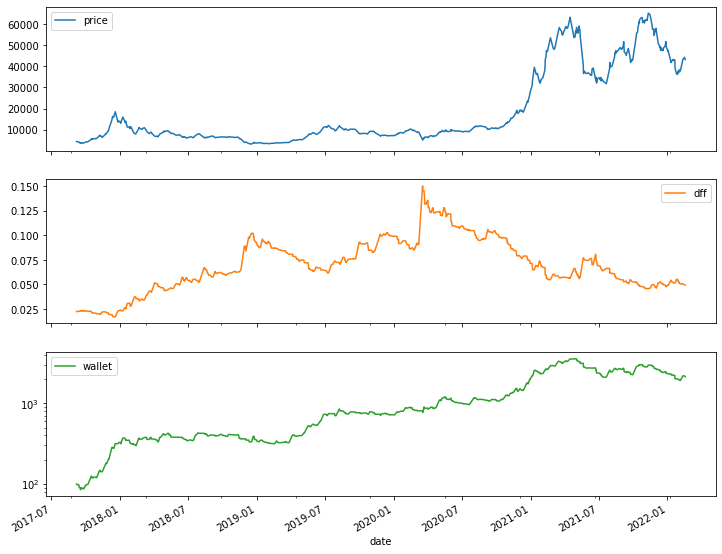

In [21]:
dfTest = df.copy()
# dfTest = df['2021-01-01':]
dt = None
dt = pd.DataFrame(columns = ['date','position', 'price', 'frais' ,'fiat', 'coins', 'wallet', 'drawBack'])

usdt = 100
initalWallet = usdt
coin = 0
wallet = 100
lastAth = 0
lastRow = dfTest.iloc[0]
fee = 0.0007
stopLoss = 0

for index, row in dfTest.iterrows():
  #Buy
  if row['close']>row['SSA'] and row['close']>row['SSB'] and row['STOCH_RSI'] < 0.8 and row['close']>row['EMA50'] and usdt > 0:
    buyPrice = row['close']
    # stopLoss = buyPrice - 0.05 * buyPrice
    coin = usdt / buyPrice
    frais = fee * coin
    coin = coin - frais
    usdt = 0
    wallet = coin * row['close']
    if wallet > lastAth:
      lastAth = wallet
    # print("Buy COIN at",buyPrice,'$ the', index)
    myrow = {'date': index,'position': "Buy",'price': buyPrice,'frais': frais,'fiat': usdt,'coins': coin,'wallet': wallet,'drawBack':(wallet-lastAth)/lastAth}
    dt = dt.append(myrow,ignore_index=True)
  
  #Stop Loss
  # elif row['low'] < stopLoss and coin > 0:
  #   sellPrice = stopLoss
  #   usdt = coin * sellPrice
  #   frais = 0.0002 * usdt
  #   usdt = usdt - frais
  #   coin = 0
  #   wallet = usdt
  #   if wallet > lastAth:
  #     lastAth = wallet
  #   # print("Sell COIN at",sellPrice,'$ the', index)
  #   myrow = {'date': index,'position': "Sell",'price': sellPrice,'frais': frais,'fiat': usdt,'coins': coin,'wallet': wallet,'drawBack':(wallet-lastAth)/lastAth}
  #   dt = dt.append(myrow,ignore_index=True)    

  # Sell
  elif (row['close'] < row['SSA'] or row['close'] < row['SSB']) and row['STOCH_RSI'] > 0.2 and coin > 0:
    sellPrice = row['close']
    usdt = coin * sellPrice
    frais = fee * usdt
    usdt = usdt - frais
    coin = 0
    wallet = usdt
    if wallet > lastAth:
      lastAth = wallet
    # print("Sell COIN at",sellPrice,'$ the', index)
    myrow = {'date': index,'position': "Sell",'price': sellPrice,'frais': frais,'fiat': usdt,'coins': coin,'wallet': wallet,'drawBack':(wallet-lastAth)/lastAth}
    dt = dt.append(myrow,ignore_index=True)
  
  lastRow = row

#///////////////////////////////////////
print("Period : [" + str(dfTest.index[0]) + "] -> [" +str(dfTest.index[len(dfTest)-1]) + "]")
dt = dt.set_index(dt['date'])
dt.index = pd.to_datetime(dt.index)
dt['resultat'] = dt['wallet'].diff()
dt['resultat%'] = dt['wallet'].pct_change()*100
dt.loc[dt['position']=='Buy','resultat'] = None
dt.loc[dt['position']=='Buy','resultat%'] = None

dt['tradeIs'] = ''
dt.loc[dt['resultat']>0,'tradeIs'] = 'Good'
dt.loc[dt['resultat']<=0,'tradeIs'] = 'Bad'

iniClose = dfTest.iloc[0]['close']
lastClose = dfTest.iloc[len(dfTest)-1]['close']
holdPorcentage = ((lastClose - iniClose)/iniClose) * 100
algoPorcentage = ((wallet - initalWallet)/initalWallet) * 100
vsHoldPorcentage = ((algoPorcentage - holdPorcentage)/holdPorcentage) * 100

print("Starting balance : 100 $")
print("Final balance :",round(wallet,2),"$")
print("Performance vs US Dollar :",round(algoPorcentage,2),"%")
print("Buy and Hold Performence :",round(holdPorcentage,2),"%")
print("Performance vs Buy and Hold :",round(vsHoldPorcentage,2),"%")
print("Number of negative trades : ",dt.groupby('tradeIs')['date'].nunique()['Bad'])
print("Number of positive trades : ",dt.groupby('tradeIs')['date'].nunique()['Good'])
print("Average Positive Trades : ",round(dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].sum()/dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].count(),2),"%")
print("Average Negative Trades : ",round(dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].sum()/dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].count(),2),"%")
idbest = dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].idxmax()
idworst = dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].idxmin()
print("Best trade +"+str(round(dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].max(),2)),"%, the ",dt['date'][idbest])
print("Worst trade",round(dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].min(),2),"%, the ",dt['date'][idworst])
print("Worst drawBack", str(100*round(dt['drawBack'].min(),2)),"%")
print("Total fee : ",round(dt['frais'].sum(),2),"$")

dt['dff'] = dt['wallet']/dt['price']

dt[['price','dff','wallet']].plot(subplots=True, figsize=(12,10))
plt.semilogy()

print('PLOT')
# dt